              Symptom  Wilcoxon_Statistic       P_Value
0       pain_6_months                90.0  3.705512e-09
1    urgency_6_months                82.0  1.756897e-09
2  frequency_6_months               110.0  2.070066e-08


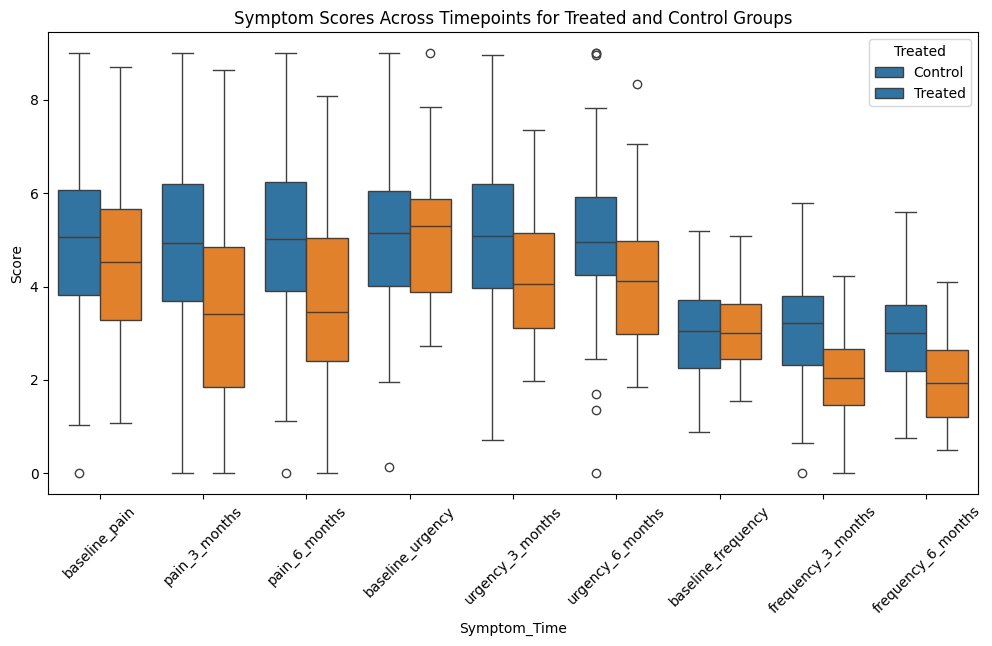

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import mahalanobis
from scipy.optimize import linear_sum_assignment
from scipy.stats import wilcoxon

# Define number of patients
n_treated = 50
n_controls = 100
n_patients = n_treated + n_controls

# Set seed for reproducibility
np.random.seed(42)

# Generate baseline symptom data
baseline_data = {
    "pain": np.clip(np.random.normal(loc=5, scale=2, size=n_patients), 0, 9),
    "urgency": np.clip(np.random.normal(loc=5, scale=1.5, size=n_patients), 0, 9),
    "frequency": np.clip(np.random.normal(loc=3, scale=1, size=n_patients), 0, 9),
}

# Create treated and control groups
treated = pd.DataFrame({
    'id': np.arange(n_treated),
    'is_treated': True,
    'baseline_pain': baseline_data["pain"][:n_treated],
    'baseline_urgency': baseline_data["urgency"][:n_treated],
    'baseline_frequency': baseline_data["frequency"][:n_treated],
})

controls = pd.DataFrame({
    'id': np.arange(n_treated, n_patients),
    'is_treated': False,
    'baseline_pain': baseline_data["pain"][n_treated:],
    'baseline_urgency': baseline_data["urgency"][n_treated:],
    'baseline_frequency': baseline_data["frequency"][n_treated:],
})

# Function to apply symptom changes over time
def apply_symptom_changes(df, treated_effect=(-1, 0.5), control_effect=(0, 0.5)):
    np.random.seed(42)
    
    for time in ['3_months', '6_months']:
        if df['is_treated'].iloc[0]:  # Treated group
            df[f'pain_{time}'] = np.clip(df['baseline_pain'] + np.random.normal(*treated_effect, len(df)), 0, 9)
            df[f'urgency_{time}'] = np.clip(df['baseline_urgency'] + np.random.normal(*treated_effect, len(df)), 0, 9)
            df[f'frequency_{time}'] = np.clip(df['baseline_frequency'] + np.random.normal(*treated_effect, len(df)), 0, 9)
        else:  # Control group
            df[f'pain_{time}'] = np.clip(df['baseline_pain'] + np.random.normal(*control_effect, len(df)), 0, 9)
            df[f'urgency_{time}'] = np.clip(df['baseline_urgency'] + np.random.normal(*control_effect, len(df)), 0, 9)
            df[f'frequency_{time}'] = np.clip(df['baseline_frequency'] + np.random.normal(*control_effect, len(df)), 0, 9)
    
    return df

# Apply changes
treated = apply_symptom_changes(treated, treated_effect=(-1, 0.5))
controls = apply_symptom_changes(controls, control_effect=(0, 0.5))

# Combine datasets
df_final = pd.concat([treated, controls]).reset_index(drop=True)

# --- Mahalanobis Distance Calculation ---
features = ['baseline_pain', 'baseline_urgency', 'baseline_frequency']

# Extract symptom matrices
X_treated = treated[features].values
X_controls = controls[features].values

# Compute covariance matrix and its inverse
cov_matrix = np.cov(np.vstack([X_treated, X_controls]).T)  
inv_cov_matrix = np.linalg.inv(cov_matrix)  

# Compute pairwise Mahalanobis distances
cost_matrix = np.zeros((n_treated, n_controls))
for i in range(n_treated):
    for j in range(n_controls):
        cost_matrix[i, j] = mahalanobis(X_treated[i], X_controls[j], inv_cov_matrix)

# Perform optimal pair matching using the Hungarian algorithm
row_ind, col_ind = linear_sum_assignment(cost_matrix)
matched_pairs = [(treated.iloc[i]['id'], controls.iloc[j]['id']) for i, j in zip(row_ind, col_ind)]

df_matched = pd.DataFrame(matched_pairs, columns=['treated_id', 'control_id'])

# Perform Wilcoxon Signed-Rank Test
def perform_wilcoxon_test(df_matched, treated, controls):
    test_results = []
    
    for symptom in ['pain_6_months', 'urgency_6_months', 'frequency_6_months']:
        treated_values = df_matched['treated_id'].map(treated.set_index('id')[symptom])
        control_values = df_matched['control_id'].map(controls.set_index('id')[symptom])
        
        stat, p_value = wilcoxon(treated_values, control_values)
        test_results.append((symptom, stat, p_value))
    
    return pd.DataFrame(test_results, columns=['Symptom', 'Wilcoxon_Statistic', 'P_Value'])

# Perform Wilcoxon test
df_wilcoxon_results = perform_wilcoxon_test(df_matched, treated, controls)

# Display results
print(df_wilcoxon_results)

# --- Data Visualization ---
def plot_boxplots(df):
    melted_df = df.melt(id_vars=['is_treated'], 
                        value_vars=['baseline_pain', 'pain_3_months', 'pain_6_months',
                                    'baseline_urgency', 'urgency_3_months', 'urgency_6_months',
                                    'baseline_frequency', 'frequency_3_months', 'frequency_6_months'],
                        var_name='Symptom_Time', value_name='Score')
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Symptom_Time', y='Score', hue='is_treated', data=melted_df)
    plt.xticks(rotation=45)
    plt.title('Symptom Scores Across Timepoints for Treated and Control Groups')
    plt.legend(title='Treated', labels=['Control', 'Treated'])
    plt.show()

# Generate box plots
plot_boxplots(df_final)
